# Variational AutoEncoder (VAE)
In the project, we construct a VAE network to re-generate the animation images. First, we inputs the dataset of the animation images and prprocess the images. Second, we construct the VAE network including setting the hyper-parameters of number of layers, kernels of the convolution layer... . Then, we train the network and show re-generated images and generated images. Otherwise, we adjust the loss function by mutiply the KL term by 10 and 0, and compare the results of re-generated images and generated images between different KL term 
coefficients.

In [1]:
import numpy as np
import pandas as pd

import torch
from torchvision import transforms

from modules.anime_dataset import AnimeDataset
from modules.train import train
from modules.line_plot import LinePlot
from modules.image_plot import ImagePlot

### 1. Data
We inputs the animation images and package them into Anime dataset.

In [2]:
train_set = AnimeDataset(
    root='.',
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

### 2. Training
We construct the VAE network including setting the hyper-parameters of number of layers, kernels of the convolution layer and train the network. Then, we train the network 2000 epochs.

In [3]:
print(f"Gpu available : {torch.cuda.is_available()}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Gpu available : False


In [4]:
KL_coefficient = 1
vae_network, manager = train(train_set, KL_coefficient=KL_coefficient, device=device)
torch.save(vae_network.state_dict(), f'vae_network_{KL_coefficient}.ckpt')

,run,epoch,loss,epoch duration,run duration,lr,batch_size
0,1,100,865.526628,0.109937,11.330752,0.001,100
1,1,200,540.792383,0.108938,22.433045,0.001,100
2,1,300,425.141797,0.108947,33.638118,0.001,100
3,1,400,362.044792,0.108938,44.758561,0.001,100
4,1,500,322.686654,0.117933,56.226546,0.001,100
5,1,600,293.428288,0.117338,67.356484,0.001,100
6,1,700,273.028581,0.109941,78.786144,0.001,100
7,1,800,257.536328,0.108947,90.082618,0.001,100
8,1,900,247.177881,0.107930,101.395417,0.001,100
9,1,1000,239.040723,0.112946,112.663669,0.001,100


In [21]:
# vae_network = VAE()
# vae_network.load_state_dict(torch.load('vae_network.ckpt', map_location=device))

<All keys matched successfully>

### 3. Learning curve
We track the loss during training phase and show the learning curve plot.

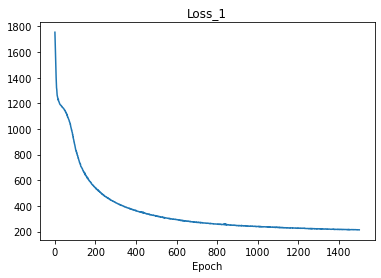

In [5]:
df_all = pd.DataFrame(manager.run_data)
ys = df_all['loss']
LinePlot.learning_curve(df_all['epoch'], ys, title=f"Loss_{KL_coefficient}")

### 4. Re-generated Images
After we train the network, we sample some original images and compare them with the re-generates images.

In [6]:
vae_network.eval()

VAE(
  (ec_conv1): Conv2d(3, 6, kernel_size=(6, 6), stride=(2, 2))
  (ec_bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ec_conv2): Conv2d(6, 12, kernel_size=(6, 6), stride=(2, 2))
  (ec_bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ec_conv3): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2))
  (ec_bn3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ec_fc1): Linear(in_features=600, out_features=128, bias=True)
  (ec_bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ec_fc2_mu): Linear(in_features=128, out_features=20, bias=True)
  (ec_fc2_lnvar): Linear(in_features=128, out_features=20, bias=True)
  (dc_fc1): Linear(in_features=20, out_features=128, bias=True)
  (dc_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dc_fc2): Linear(in_features=128, out_features=600, bias=True)
  (dc_bn2): Ba

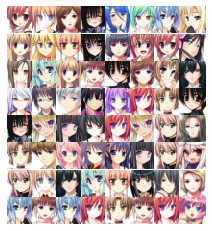

In [7]:
sample_index = np.random.randint(len(train_set), size=64)
original_images_tensor = train_set.data[sample_index]
ImagePlot.sample_images(original_images_tensor, (8, 8), f'original_img_{KL_coefficient}')

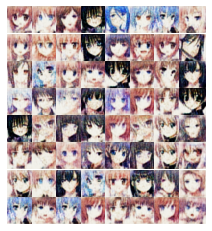

In [8]:
with torch.no_grad():
    regenerate_images_tensor, _, _ = vae_network(original_images_tensor.to(device))
ImagePlot.sample_images(regenerate_images_tensor, (8, 8), f'regenerate_img_{KL_coefficient}')

### 5. Generated Images
We random generate some values of z from standard normal distribution and generate the images.

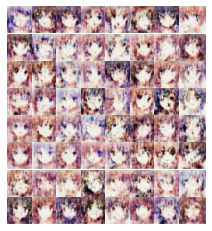

In [9]:
latent_dim = 20
sample_num = 64
zs = torch.randn(sample_num, latent_dim).to(device)
with torch.no_grad():
    generate_images_tensor = vae_network.decode(zs)
        
ImagePlot.sample_images(generate_images_tensor, (8, 8), f'generate_img_{KL_coefficient}')

### 6. Change Between Two Images
We random generate two value of z and generate other value of z by interpolation between them. Show the change of the images because of the change of z.

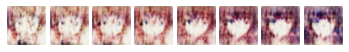

In [10]:
sample_num = 8
z_start = torch.randn(1, latent_dim)
z_end = torch.randn(1, latent_dim)
diff_of_z = (z_end-z_start) / (sample_num-1)
z_tensor = torch.zeros(sample_num, latent_dim)
for i in range(sample_num):
    z_tensor[i] = (z_start + diff_of_z*i).to(device)
    
with torch.no_grad():
    images_change_tensor = vae_network.decode(z_tensor)
        
ImagePlot.sample_images(images_change_tensor, (1, 8), f'images_change_{KL_coefficient}',
                        wspace=0.1) 

### 7. Mutiply KL Term by 100
We mutiply the KL term by 100 in loss function. Show the reults of re-generated images and generated images and observe the effect of it.

In [11]:
KL_coefficient = 100
vae_network, manager = train(train_set, KL_coefficient=KL_coefficient, device=device)
torch.save(vae_network.state_dict(), f'vae_network_{KL_coefficient}.ckpt')

,run,epoch,loss,epoch duration,run duration,lr,batch_size
0,1,100,1154.444271,0.110953,11.602395,0.001,100
1,1,200,1048.319987,0.108928,23.105659,0.001,100
2,1,300,899.683464,0.110936,34.406989,0.001,100
3,1,400,839.045378,0.107924,45.724757,0.001,100
4,1,500,777.792448,0.115933,56.954567,0.001,100
5,1,600,754.050977,0.108951,68.031496,0.001,100
6,1,700,760.722721,0.108938,79.265573,0.001,100
7,1,800,748.741732,0.108928,90.243968,0.001,100
8,1,900,742.301432,0.108947,101.249580,0.001,100
9,1,1000,744.654427,0.108938,112.219541,0.001,100


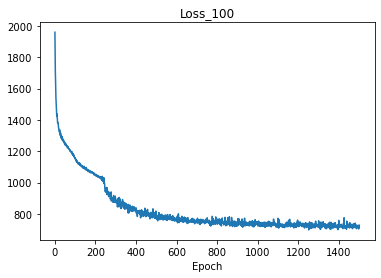

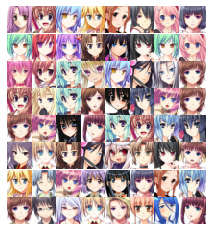

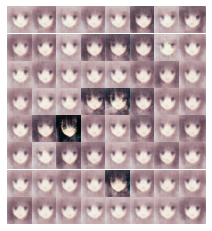

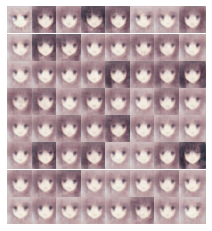

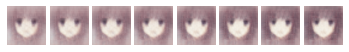

In [12]:
# learning curve
df_all = pd.DataFrame(manager.run_data)
ys = df_all['loss']
LinePlot.learning_curve(df_all['epoch'], ys, title=f"Loss_{KL_coefficient}")

# regenerated images
vae_network.eval()

sample_index = np.random.randint(len(train_set), size=64)
original_images_tensor = train_set.data[sample_index]
ImagePlot.sample_images(original_images_tensor, (8, 8), f'original_img_{KL_coefficient}')

with torch.no_grad():
    regenerate_images_tensor, _, _ = vae_network(original_images_tensor.to(device))
ImagePlot.sample_images(regenerate_images_tensor, (8, 8), f'regenerate_img_{KL_coefficient}')

# generated images
latent_dim = 20
sample_num = 64
zs = torch.randn(sample_num, latent_dim).to(device)
with torch.no_grad():
    generate_images_tensor = vae_network.decode(zs)

ImagePlot.sample_images(generate_images_tensor, (8, 8), f'generate_img_{KL_coefficient}')

# change between two images
sample_num = 8
z_start = torch.randn(1, latent_dim)
z_end = torch.randn(1, latent_dim)
diff_of_z = (z_end-z_start) / (sample_num-1)
z_tensor = torch.zeros(sample_num, latent_dim)
for i in range(sample_num):
    z_tensor[i] = (z_start + diff_of_z*i).to(device)

with torch.no_grad():
    images_change_tensor = vae_network.decode(z_tensor)

ImagePlot.sample_images(images_change_tensor, (1, 8), f'images_change_{KL_coefficient}',
                          wspace=0.1) 


### 8. Mutiply KL Term by 0
We mutiply the KL term by 0 in loss function. Show the reults of re-generated images and generated images and observe the effect of it.

In [13]:
KL_coefficient = 0
vae_network, manager = train(train_set, KL_coefficient=KL_coefficient, device=device)
torch.save(vae_network.state_dict(), f'vae_network_{KL_coefficient}.ckpt')

,run,epoch,loss,epoch duration,run duration,lr,batch_size
0,1,100,1207.688672,0.108147,10.850415,0.001,100
1,1,200,1168.897786,0.132925,21.847780,0.001,100
2,1,300,961.813997,0.106930,32.869176,0.001,100
3,1,400,555.087500,0.106938,44.240728,0.001,100
4,1,500,395.707194,0.107938,55.138185,0.001,100
5,1,600,299.800977,0.107939,66.024028,0.001,100
6,1,700,253.787109,0.107938,77.036971,0.001,100
7,1,800,227.147266,0.107938,88.317844,0.001,100
8,1,900,209.433089,0.108587,99.289959,0.001,100
9,1,1000,197.873535,0.115186,110.430788,0.001,100


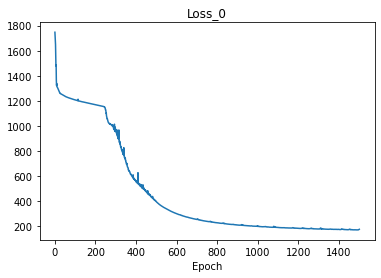

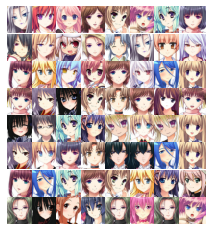

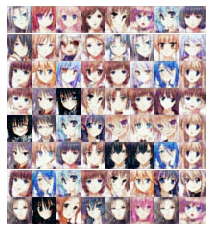

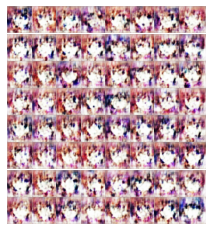

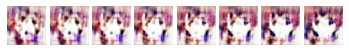

In [14]:
# learning curve
df_all = pd.DataFrame(manager.run_data)
ys = df_all['loss']
LinePlot.learning_curve(df_all['epoch'], ys, title=f"Loss_{KL_coefficient}")

# regenerated images
vae_network.eval()

sample_index = np.random.randint(len(train_set), size=64)
original_images_tensor = train_set.data[sample_index]
ImagePlot.sample_images(original_images_tensor, (8, 8), f'original_img_{KL_coefficient}')

with torch.no_grad():
    regenerate_images_tensor, _, _ = vae_network(original_images_tensor.to(device))
ImagePlot.sample_images(regenerate_images_tensor, (8, 8), f'regenerate_img_{KL_coefficient}')

# generated images
latent_dim = 20
sample_num = 64
zs = torch.randn(sample_num, latent_dim).to(device)
with torch.no_grad():
    generate_images_tensor = vae_network.decode(zs)

ImagePlot.sample_images(generate_images_tensor, (8, 8), f'generate_img_{KL_coefficient}')

# change between two images
sample_num = 8
z_start = torch.randn(1, latent_dim)
z_end = torch.randn(1, latent_dim)
diff_of_z = (z_end-z_start) / (sample_num-1)
z_tensor = torch.zeros(sample_num, latent_dim)
for i in range(sample_num):
    z_tensor[i] = (z_start + diff_of_z*i).to(device)

with torch.no_grad():
    images_change_tensor = vae_network.decode(z_tensor)

ImagePlot.sample_images(images_change_tensor, (1, 8), f'images_change_{KL_coefficient}',
                          wspace=0.1) 
